In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io
import itertools
import filters
import homography
import rectification
import utils
from mops import *

# Detect Corners

In [20]:
im1 = utils.read_img("data/plush1.jpg", gray=True)
im1.shape

(756, 1344)

In [21]:
im2 = utils.read_img("data/plush2.jpg", gray=True)
im2.shape

(756, 1344)

In [22]:
corners1 = get_corners(im1)
len(corners1)

AssertionError: (756, 1344)

In [ ]:
# utils.plot_corners(im1, np.array([c.coord for c in corners1]))
# plt.imshow(strengths1)

In [10]:
corners2 = get_corners(im2)
len(corners2)
# utils.plot_corners(im2, corners2)
# plt.imshow(strengths2)

965

In [15]:
type(corners1)

list

# Do Adaptive Non-Maximal Suppression

In [17]:
detected1 = anms(corners1)

AttributeError: 'function' object has no attribute 'remove'

# Match Features

In [42]:
patches1 = get_patches(im1, corners1)
patches2 = get_patches(im2, corners2)

In [88]:
features1 = [Feature(c, p) for c, p in zip(corners1, patches1)]
features2 = [Feature(c, p) for c, p in zip(corners2, patches2)]

In [98]:
combos = np.array(list(itertools.product(features1, features2)))
combos.shape

(917715, 2)

In [99]:
dist2(patches1, patches2)

ValueError: too many values to unpack (expected 2)

In [100]:
patches1.shape

(951, 8, 8)

In [108]:
c1 = corners1
c2 = corners2
ndata, dimx = c1.shape #num_points1, dim1
ncenters, dimc = c2.shape #num_points2, dim2

In [109]:
np.ones((ncenters, 1)).shape

(965, 1)

In [107]:
np.sum((x ** 2).T, axis=0).shape

(951,)

In [111]:
a = (np.ones((ncenters, 1)) * np.sum((x ** 2).T, axis=0)).T
a.shape

(951, 965)

In [114]:
b = np.ones((ndata, 1)) * np.sum((c ** 2).T, axis=0)
b.shape

(951, 965)

In [9]:
a = np.array([1,2,3,4,1,2,3,4,1,2,3,4])
a = np.reshape(a, (3, 4))
a

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [11]:
a[:, ::3]

array([[1, 4],
       [1, 4],
       [1, 4]])

In [12]:
corners1[0]

array([  25, 1320])

In [14]:
im1[25, 1320]

array([0.92044222, 0.74115697, 0.42926749])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 8, 3)

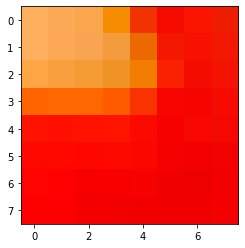

In [31]:
r, c = 25, 1320
patch = im1[r - 20 : r + 20, c - 20 : c + 20]
patch = skimage.transform.resize(patch, (8, 8))
patch = normalize(patch)
plt.imshow(patch)
patch.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 8, 3)

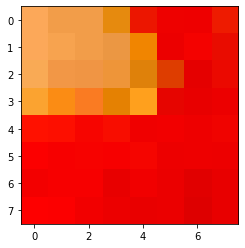

In [30]:
r, c = 25, 1320
patch = im1[r - 20 : r + 20, c - 20 : c + 20]
patch = patch[::5, ::5, :]
patch = normalize(patch)
plt.imshow(patch)
patch.shape

In [41]:
a = [1, 2, 3, 4]

In [42]:
a.remove(1z)

In [43]:
a

[2, 3, 4]